In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict
from sklearn.metrics import normalized_mutual_info_score

def CLOPE(df, k, r, real_label="missing!"):
    
    #whatever is passed the column of the class
    if real_label!="missing!":
        df_tmp = df.drop([real_label], axis=1, inplace=False)
    else: df_tmp = df
    
    #initialize the table (index in df | cluster label)
    table = pd.DataFrame(columns=['items', 'index', 'cluster_label', 'real_label'], index=range(df_tmp.shape[0]))
    table['index'] = np.arange(df_tmp.shape[0])
    table['cluster_label'] = -1
    table['items'] = df_tmp.apply(lambda row: row.tolist(), axis=1)
    if real_label!="missing!": table['real_label'] = df[real_label]
    
    #initialize the empty clusters
    # S -> number of items
    # W -> width
    # N -> number of transactions
    # Items -> list of items (eventually repeated)
    Clusters = pd.DataFrame(columns=['S', 'W', 'N', 'Items'], index=range(k))
    for index, c in Clusters.iterrows():
        c['S'] = 0
        c['W'] = 0
        c['N'] = 0
        c['Items'] = []
        
    
    #FIRST STEP
    for index, ts in table.iterrows():
        new_label = maximize(Clusters, ts, r)
        table.loc[index, 'cluster_label'] = new_label
        
        
    #SECOND STEP
    moved=False 
    while(not moved):
        moved=False
        for index, ts in table.iterrows():
            old_label = ts['cluster_label']
            new_label = maximize(Clusters, ts, r)
            if new_label!=old_label:
                table.loc[index, 'cluster_label'] = new_label
                moved = True
                
    #calculating metric for clustering evaluation
    if real_label != "missing!":
        real=table['real_label'].tolist()
        pred=table['cluster_label'].tolist()
        print("purity: ", Purity(real, pred))
        print("mutual info score: ", normalized_mutual_info_score(real, pred))
    
    return table, Clusters

In [3]:
def maximize(Clusters, ts, r):
    
    label = ts['cluster_label']
    new_label = label #at starting point the new_label is the previous label
    indices_empty = Clusters.loc[Clusters['N'] == 0].index #list of empty cluster
    
    #CASE 0: There's at least one cluster with 0 elements
    if len(indices_empty)!=0:
        update_cluster(Clusters.loc[indices_empty[0]], ts)
        new_label = indices_empty[0]

#CASE 1: all the clusters have at least 1 element
    #remove ts from its Cluster (if ts belong to a cluster)
    else:
        #to avoid to remove the element from a cluster with a single element
        if label!=-1:
            if Clusters.loc[label]['N']==1:
                return label
        
        #REMOVE
        #if the element belong to a cluster...
        if label!=-1:
            #...remove the transaction from the cluster
            Clusters.loc[label]['S']-=len(ts['items'])
            Clusters.loc[label]['N']-=1
            Clusters.loc[label]['Items'] = remove_occ(Clusters.loc[label]['Items'], ts['items'])
            Clusters.loc[label]['W'] = len(set(Clusters.loc[label]['Items']))

        #UPDATE
        #update the cluster with the new transaction
        profits = Clusters.apply(lambda row: DeltaAdd(row, ts, r), axis=1).tolist()
        maxprofit = max(profits)
        new_label = profits.index(maxprofit)
        #update the corresponding cluster and ts.label
        update_cluster(Clusters.loc[new_label], ts)
        
    return new_label

In [4]:
#calculate the increment Profit considering a specific cluster C
def DeltaAdd(C, ts, r):

    S_new = C['S'] + len(ts['items'])
    W_new = C['W']

    for i in set(ts['items']):
        if not i in C['Items']:
            W_new+=1
            
    result = ( S_new*( (C['N']+1)/(W_new**r) ) ) - ( C['S']*( C['N']/(C['W']**r) ) )
    
    return result

In [5]:
def remove_occ(main_list, remove_list):
    
    main_counter = Counter(main_list)
    remove_counter = Counter(remove_list)

    result_counter = main_counter - remove_counter
        
    return list(result_counter.elements())

In [6]:
def update_cluster(C, ts):
    C['N']+=1
    C['S']+=len(ts['items'])
    C['Items']+=ts['items']
    C['W']=len(set(C['Items']))

In [7]:
def Purity(real, pred):
    
    mapping = {value: index for index, value in enumerate(set(real))}
    # Map the list of strings to numbers
    real_map = [mapping[item] for item in real]
    
    
    purity_val = 0
    cluster_count = defaultdict(lambda: [0] * len(set(real_map)))

    for p, r in zip(pred, real_map):
        cluster_count[p][r] += 1

    for label in cluster_count:
        purity_val += np.max(cluster_count[label])

    return 1.0 * purity_val / len(real)

## Testing on FEATURES dataset

In [45]:
df=pd.read_csv('../Ravdess_TRAIN_transformed.csv')
df = df.drop(['repetition', 'statement'], axis=1, inplace=False)
df['actor'] = df['actor'].astype(str)
df_copy = df

### selecting only one statistics (optional)

In [39]:
# selecting only one statistics (mfcc, stft, sc...)
selected_columns = df.iloc[:, :5]  # Select the first 7 columns

basic_stat = ['sum', 'max', 'kur', 'skew']
basic_stat_df = df[basic_stat]

mfcc_stat = ['mfcc_sum', 'mfcc_mean', 'mfcc_min', 'mfcc_max', 'mfcc_kur', 'mfcc_skew']
mfcc_df = df[mfcc_stat]
df = (selected_columns.join(mfcc_df)).join(basic_stat_df)

#df = selected_columns.join(df.filter(like='mfcc'))  # Select columns containing 'mfcc' in their name

### discretization

In [40]:
for column in df.select_dtypes(include=np.number):
    # Compute bin edges based on statistical distribution
    n=12
    bin_edges = np.linspace(df[column].min(), df[column].max(), num=n+1)
    
    # Discretize the column into n bins
    df[column] = pd.cut(df[column], bins=bin_edges, labels=False, include_lowest=True)

### renaming

In [15]:
for column in df.columns:
    # Apply the renaming operation using the applymap method
    df[column] = df[column].apply(lambda x: f"{column}_{x}")

In [41]:
%%time
table, clusters = CLOPE(df, k=8, r=2.2, real_label="emotion")

purity:  0.1652078774617068
mutual info score:  0.01165413940388552
CPU times: total: 8.31 s
Wall time: 8.32 s


In [42]:
table['cluster_label'].value_counts()

6    416
1    325
2    312
7    215
5    208
3    188
0    163
4      1
Name: cluster_label, dtype: int64

## Testing on TIME SERIES dataset

In [53]:
from tslearn.piecewise import SymbolicAggregateApproximation
import string

Y_train = pd.read_csv("RavdessTimeSeries_Y_train.csv")
X_train = np.load("RavdessTimeSeriesTrim_X_train.npy")

### selecting a subset

In [54]:
#mask
mask_sub = (Y_train["sex"]=='M')&(Y_train["vocal_channel"]=='speech')&(Y_train["emotional_intensity"]=='normal')&(Y_train["statement"]=='Kids are talking by the door')
indices_sub = Y_train.index[mask_sub]

#selecting a subset of X
sub_X = X_train[indices_sub]
sub_Y = Y_train.loc[indices_sub]

sub_X = sub_X[:, 9200:240000]

sub_X.shape

(144, 230800)

### noise removing & approximation (SAX)

In [55]:
%%time
w = 16
sub_X_cleaned = []

for ts_array in sub_X:
    # Convert ts_array to a pandas Series
    ts_series = pd.Series(ts_array)
    # Calculate ts_det using rolling mean
    ts_det = ((ts_series - ts_series.mean()) / ts_series.std()).rolling(window=w).mean()
    # Convert ts_det back to a NumPy array
    cleaned_array = ts_det.to_numpy()
    sub_X_cleaned.append(cleaned_array)

sub_X = np.array(sub_X_cleaned)

CPU times: total: 1.94 s
Wall time: 1.94 s


In [56]:
%%time
n_sax_symbols = 12
segments = 2000
sax = SymbolicAggregateApproximation(n_segments=segments, 
                                     alphabet_size_avg=n_sax_symbols,
                                    scale=True)
X_sax = sax.fit_transform(sub_X)

C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 144 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


CPU times: total: 1min 42s
Wall time: 1min 42s


In [57]:
reshaped_X_sax = X_sax.reshape(X_sax.shape[0], X_sax.shape[1])
df = pd.DataFrame(reshaped_X_sax)
column_names = [f"Time_{i}" for i in range(X_sax.shape[1])]
df.columns = column_names

### merging segments (optional)

In [58]:
n_to_merge = 5

# Calculate the number of columns in the new dataframe
num_columns_new = df.shape[1] // n_to_merge

# Create a new dataframe with the desired dimensions
new_df = pd.DataFrame(index=df.index, columns=range(num_columns_new))

# Iterate over the original dataframe and merge every three consecutive columns
for i in range(num_columns_new):
    start_col = i * n_to_merge
    end_col = start_col + n_to_merge
    new_df[i] = df.iloc[:, start_col:end_col].astype(str).apply('-'.join, axis=1)

df = new_df

In [59]:
#adding the class column
df = pd.concat([df, sub_Y.reset_index(drop=True)['emotion']], axis=1)

In [60]:
%%time
table, clusters = CLOPE(df, k=8, r=1, real_label="emotion")

KeyboardInterrupt: 

In [52]:
table['cluster_label'].value_counts()

5    137
0      1
1      1
3      1
6      1
7      1
4      1
2      1
Name: cluster_label, dtype: int64

# Plotting CLOPE results

In [51]:
import umap
import plotly.express as px
import matplotlib.pyplot as plt

In [47]:
emotion_mapper = {"neutral":0, "calm":1, "happy":2, "sad":3, "angry":4, "fearful":5, "disgust":6, "surprised":7}
df_copy["emotion"] = df_copy["emotion"].replace(emotion_mapper)

X, y = df_copy.drop(["emotion", "vocal_channel", "emotional_intensity", "actor", "sex"], axis=1), df_copy[["emotion"]].values.flatten()

In [58]:
manifold = umap.UMAP(n_components=2, n_neighbors=45, min_dist=0.3).fit(X, y)
X_reduced = manifold.transform(X)

In [70]:
import csv
pred_labels = table['cluster_label']

filename = "CLOPE_label.csv"
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(pred_labels)

[Text(0, -4.0, ''),
 Text(0, -2.0, ''),
 Text(0, 0.0, ''),
 Text(0, 2.0, ''),
 Text(0, 4.0, ''),
 Text(0, 6.0, ''),
 Text(0, 8.0, ''),
 Text(0, 10.0, ''),
 Text(0, 12.0, ''),
 Text(0, 14.0, ''),
 Text(0, 16.0, '')]

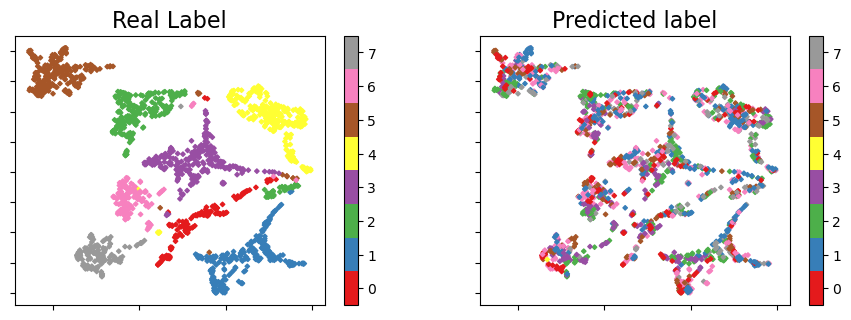

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3.5))

scatter_y = ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=5, cmap='Set1', marker='D')   #c=pred_labels
#ax1.colorbar(boundaries=np.arange(9)-0.5).set_ticks(np.arange(8))
colorbar = plt.colorbar(scatter_y, ax=ax1, boundaries=np.arange(9)-0.5)
colorbar.set_ticks(np.arange(8))
ax1.set_title('Real Label', fontsize=16)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])

scatter_pred = ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c=pred_labels, s=5, cmap='Set1', marker='D')   #c=pred_labels)
colorbar = plt.colorbar(scatter_pred, ax=ax2, boundaries=np.arange(len(set(pred_labels))+1)-0.5)
colorbar.set_ticks(np.arange(len(set(pred_labels))))
ax2.set_title('Predicted label', fontsize=16)
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])

In [ ]:
colors = pd.Categorical(pred_labels)

fig = px.scatter_3d(df, x=X_reduced[:, 0], y=X_reduced[:, 1], z=X_reduced[:, 2],
              color=colors, color_continuous_scale='jet')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()